In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'
group_size = 1
num_exps = 120
num_repeats_per_exp = 5

policies = [
    'ens jensen greedy',
    'classical ens',
    'greedy',
    # 'round robin greedy',
]
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities.shape

(3, 120, 5, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([4.32871566, 4.39507634, 4.39377535])

ens jensen greedy: 4.3287
classical ens: 4.3951
greedy: 4.3938


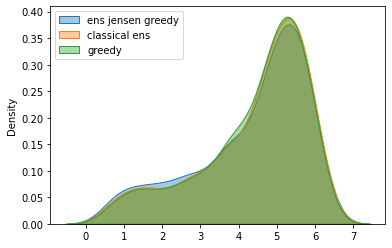

In [5]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [6]:
print(utilities.shape)
utilities

(3, 120, 5, 501)


array([[[[0.69314718, 0.69314718, 0.69314718, ..., 5.37527841,
          5.37527841, 5.37989735],
         [0.69314718, 1.09861229, 1.09861229, ..., 5.4161004 ,
          5.4161004 , 5.4161004 ],
         [0.69314718, 0.69314718, 0.69314718, ..., 5.3082677 ,
          5.3082677 , 5.3082677 ],
         [0.69314718, 1.09861229, 1.09861229, ..., 5.86363118,
          5.86363118, 5.86646806],
         [0.69314718, 0.69314718, 0.69314718, ..., 5.4161004 ,
          5.4161004 , 5.4161004 ]],

        [[0.69314718, 0.69314718, 0.69314718, ..., 5.48893773,
          5.48893773, 5.48893773],
         [0.69314718, 0.69314718, 1.09861229, ..., 5.59471138,
          5.59471138, 5.59471138],
         [0.69314718, 1.09861229, 1.38629436, ..., 5.0689042 ,
          5.0689042 , 5.07517382],
         [0.69314718, 0.69314718, 1.09861229, ..., 5.02388052,
          5.03043792, 5.0369526 ],
         [0.69314718, 1.09861229, 1.09861229, ..., 5.63121178,
          5.63121178, 5.63121178]],

        [[0.6931

In [7]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(3, 600, 501)


array([[[0.69314718, 0.69314718, 0.69314718, ..., 5.37527841,
         5.37527841, 5.37989735],
        [0.69314718, 1.09861229, 1.09861229, ..., 5.4161004 ,
         5.4161004 , 5.4161004 ],
        [0.69314718, 0.69314718, 0.69314718, ..., 5.3082677 ,
         5.3082677 , 5.3082677 ],
        ...,
        [0.69314718, 0.69314718, 1.09861229, ..., 5.42934563,
         5.42934563, 5.42934563],
        [0.69314718, 1.09861229, 1.38629436, ..., 5.34710753,
         5.34710753, 5.35185813],
        [0.69314718, 0.69314718, 0.69314718, ..., 5.43807931,
         5.43807931, 5.43807931]],

       [[0.69314718, 0.69314718, 0.69314718, ..., 4.94875989,
         4.94875989, 4.94875989],
        [0.69314718, 1.09861229, 1.09861229, ..., 4.95582706,
         4.95582706, 4.95582706],
        [0.69314718, 0.69314718, 0.69314718, ..., 5.29831737,
         5.29831737, 5.29831737],
        ...,
        [0.69314718, 0.69314718, 1.09861229, ..., 5.433722  ,
         5.433722  , 5.433722  ],
        [0.6

4.211158503065736 4.4462728258288635
0.0587785806907819
4.281000364440842 4.509152321660838
0.05703798930499904
4.282051148297527 4.505499548095709
0.055862099949545385


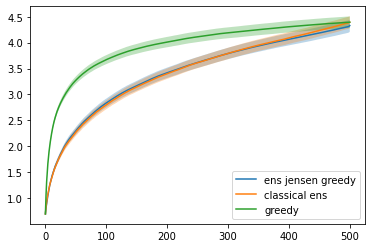

In [8]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print((upper[-1] - lower[-1]) / 4)
    
plt.legend();